In [19]:
# Import packages
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import anderson
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip

In [20]:
# Load the dataset
df = pd.read_csv('data/customer_data.csv')
df.columns

Index(['id', 'age', 'gender', 'income', 'education', 'region',
       'loyalty_status', 'purchase_frequency', 'purchase_amount',
       'product_category', 'promotion_usage', 'satisfaction_score'],
      dtype='object')

In [21]:
# Convert Categorical columns to the Category datatype
# Define categorical columns
categorical_columns = ['gender', 'education', 'region', 'loyalty_status', 'purchase_frequency',
                       'product_category', 'promotion_usage']

# For each column... convert to category
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Convert ID to String since it won't be used in the analysis
df['id'] = df['id'].astype(str)

# Confirm columns were converted
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   id                  100000 non-null  object  
 1   age                 100000 non-null  int64   
 2   gender              100000 non-null  category
 3   income              100000 non-null  int64   
 4   education           100000 non-null  category
 5   region              100000 non-null  category
 6   loyalty_status      100000 non-null  category
 7   purchase_frequency  100000 non-null  category
 8   purchase_amount     100000 non-null  int64   
 9   product_category    100000 non-null  category
 10  promotion_usage     100000 non-null  category
 11  satisfaction_score  100000 non-null  int64   
dtypes: category(7), int64(4), object(1)
memory usage: 4.5+ MB


# Check for Null Values

In [22]:
# Loop through each column and print value counts
for column in df.columns:
    print(df[column].value_counts(dropna=False))
    print("\n")

1         1
66651     1
66673     1
66672     1
66671     1
         ..
33332     1
33331     1
33330     1
33329     1
100000    1
Name: id, Length: 100000, dtype: int64


30    8867
31    8645
29    8636
28    8266
32    8034
33    7214
27    7022
34    5894
26    5882
35    4873
25    4856
36    3583
24    3576
37    2697
23    2636
38    1791
22    1790
39    1200
21    1187
20     743
40     682
41     481
19     457
42     242
18     233
17     143
43     125
16      66
44      58
15      39
45      35
47      13
14      13
46      11
13       4
12       3
48       2
49       1
Name: age, dtype: int64


Female    50074
Male      49926
Name: gender, dtype: int64


39596    12
28944    10
12803    10
36828    10
21832     9
         ..
47076     1
44614     1
14934     1
45093     1
35207     1
Name: income, Length: 40003, dtype: int64


College       39874
Bachelor      30279
HighSchool    20031
Masters        9816
Name: education, dtype: int64


East     30074
West     29935
Sout

Looking at the most common values for each variable helps to see if there is anything unusual in the data (either null values being represented differently or specific values being grossly overrepresented).

# Check for Duplicates

In [23]:
# Check for complete duplicates
if df.duplicated().any():
    print('Has complete duplicates')
else:
    print('No complete duplicates')

No complete duplicates


In [24]:
# Check to see if any IDs are duplicated
df.duplicated(subset='id').sum()

0

# Check for Outliers

In [6]:
# Drop ID column since we don't need it for this analysis
df = df.drop(columns='id')

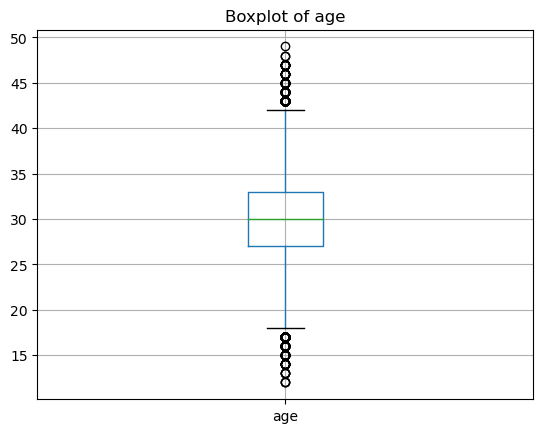

age has 513 outliers


Value counts for gender
Female    50074
Male      49926
Name: gender, dtype: int64




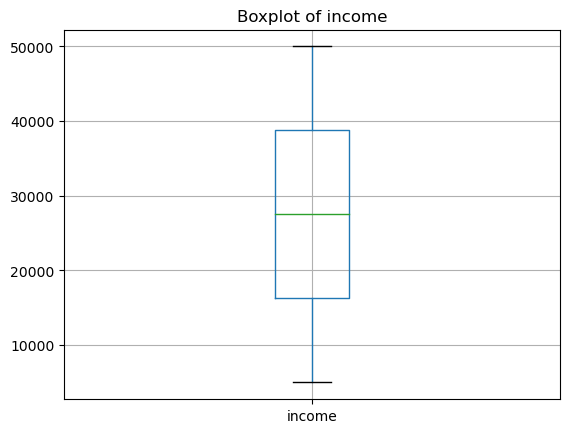

income has 0 outliers


Value counts for education
College       39874
Bachelor      30279
HighSchool    20031
Masters        9816
Name: education, dtype: int64



Value counts for region
East     30074
West     29935
South    20073
North    19918
Name: region, dtype: int64



Value counts for loyalty_status
Regular    60138
Silver     29964
Gold        9898
Name: loyalty_status, dtype: int64



Value counts for purchase_frequency
rare          50019
occasional    29886
frequent      20095
Name: purchase_frequency, dtype: int64




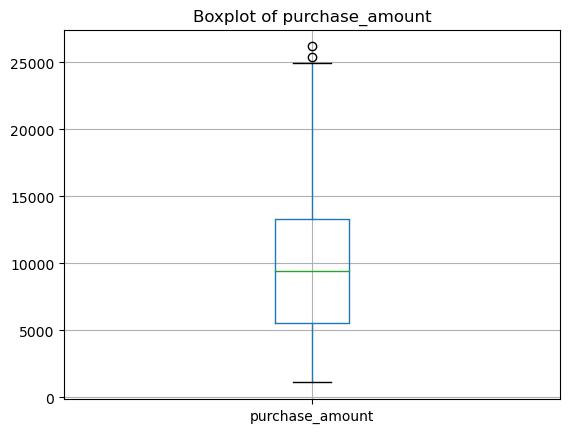

purchase_amount has 2 outliers


Value counts for product_category
Electronics    30027
Clothing       19989
Books          14925
Food           14822
Health         10123
Home            5079
Beauty          5035
Name: product_category, dtype: int64



Value counts for promotion_usage
0    69920
1    30080
Name: promotion_usage, dtype: int64




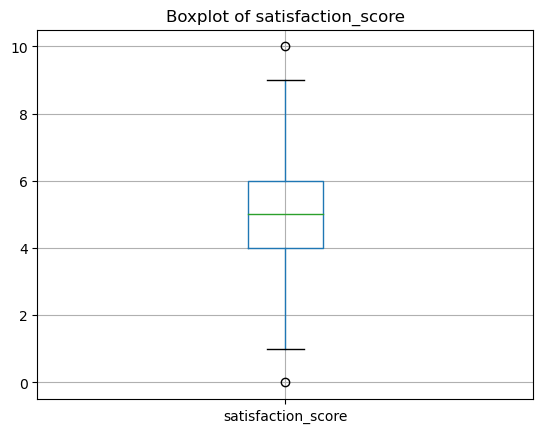

satisfaction_score has 2 outliers



In [7]:
# Create boxplot and if outliers exist, calculate using IQR method
for col in df.columns:
    if df[col].dtype != 'category':
        # Create boxplot
        df.boxplot(column=col)
        plt.title(f'Boxplot of {col}')
        plt.show()
        
        # Calculate IQR lower and upper bounds to determine outliers
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count and display outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        num_outliers = outliers.shape[0]
        print(f"{col} has {num_outliers} outliers")
        print()
        
        
    else:
        # For categorical variables, determine if any category makes up a small percentage
        print()
        print(f'Value counts for {col}')
        print(df[col].value_counts())
        print('\n')

# Summary Statistics

In [8]:
# Produce summary statistics for each variable
for col in df.columns:
    print(f'Summary statistics for {col}')
    print(df[col].describe())
    print()

Summary statistics for age
count    100000.000000
mean         30.003260
std           4.480535
min          12.000000
25%          27.000000
50%          30.000000
75%          33.000000
max          49.000000
Name: age, dtype: float64

Summary statistics for gender
count     100000
unique         2
top       Female
freq       50074
Name: gender, dtype: object

Summary statistics for income
count    100000.000000
mean      27516.269880
std       12996.782587
min        5000.000000
25%       16271.750000
50%       27584.500000
75%       38747.250000
max       50000.000000
Name: income, dtype: float64

Summary statistics for education
count      100000
unique          4
top       College
freq        39874
Name: education, dtype: object

Summary statistics for region
count     100000
unique         4
top         East
freq       30074
Name: region, dtype: object

Summary statistics for loyalty_status
count      100000
unique          3
top       Regular
freq        60138
Name: loyalty_sta

# Univariate Visualizations

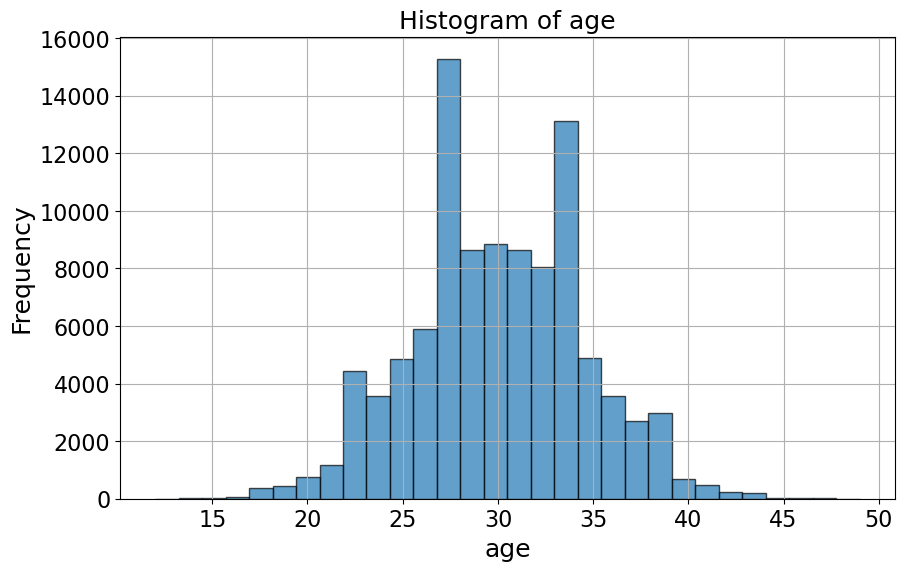

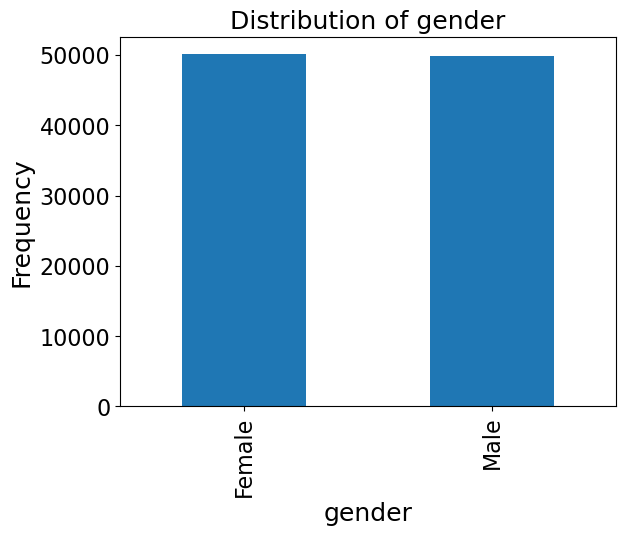

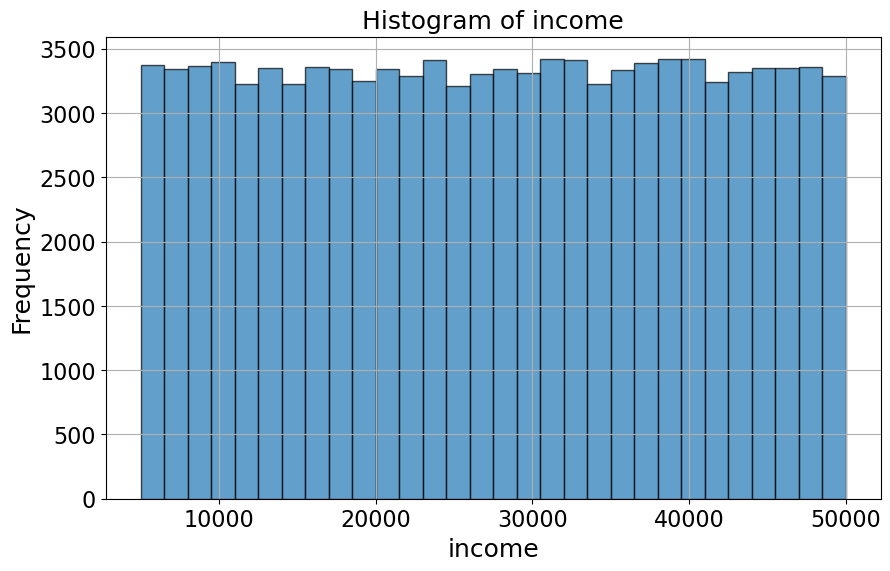

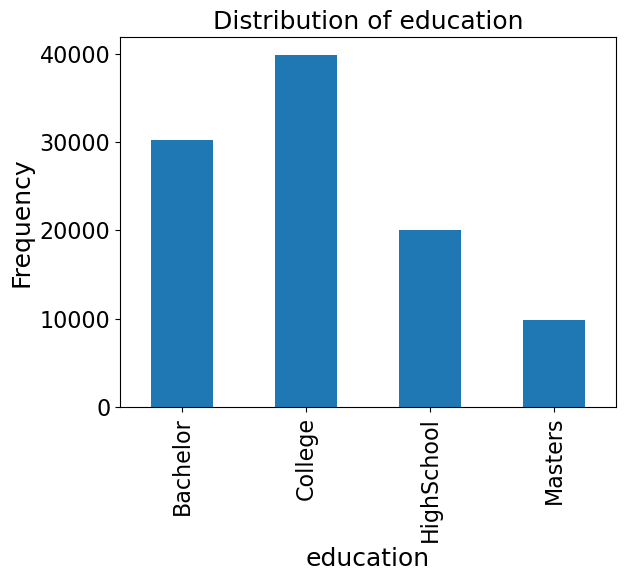

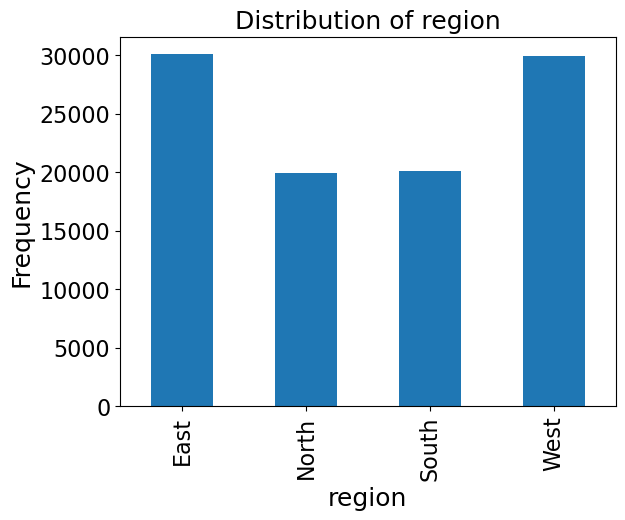

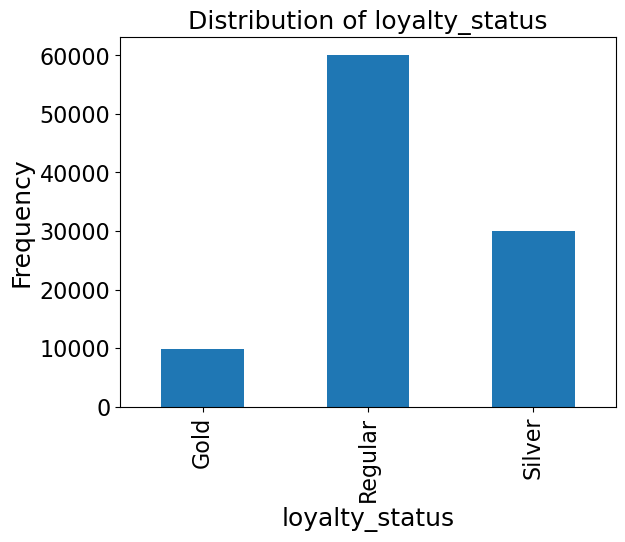

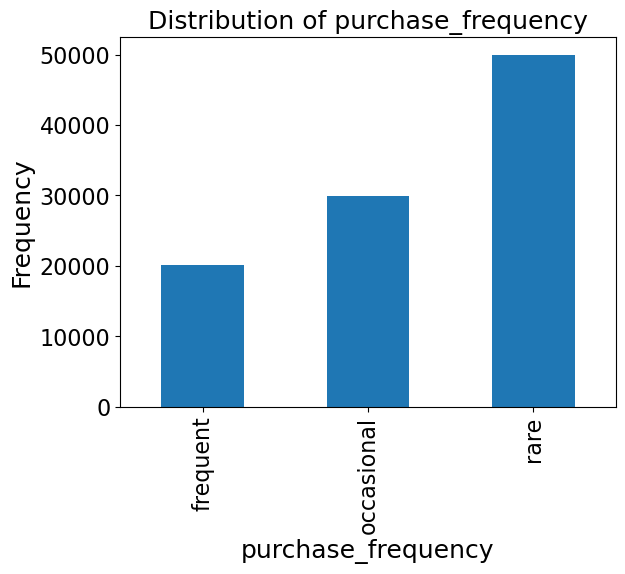

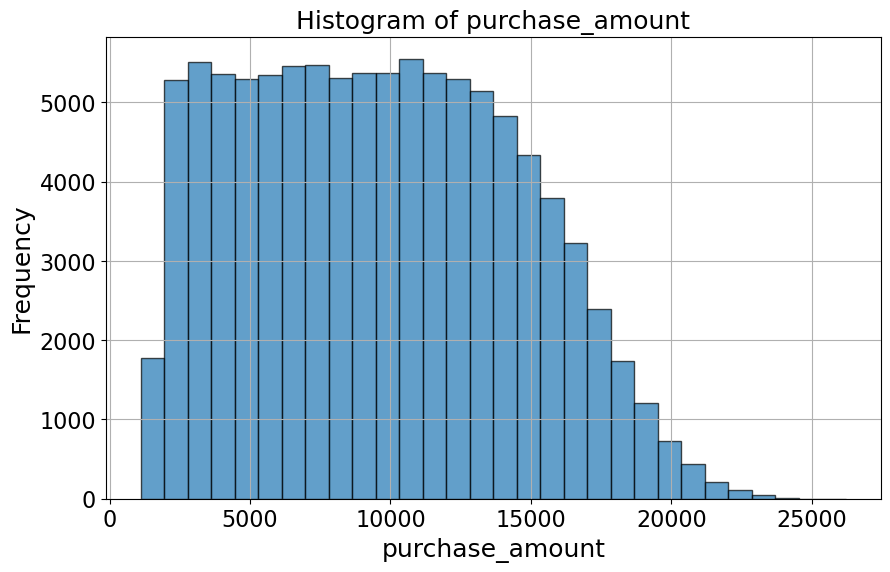

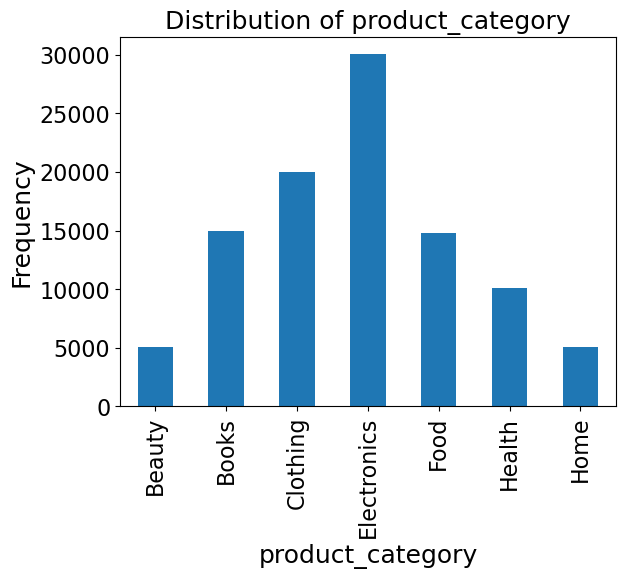

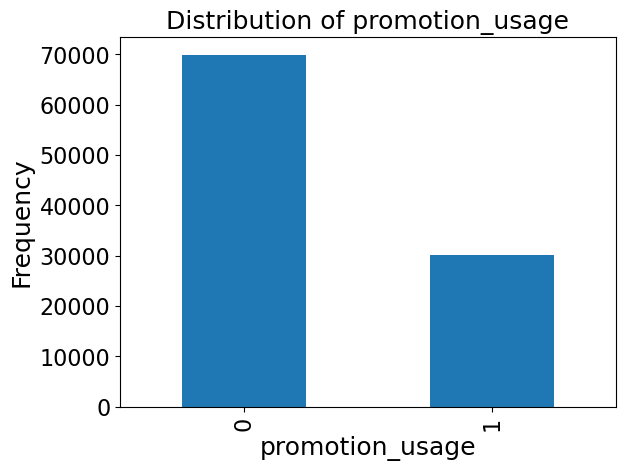

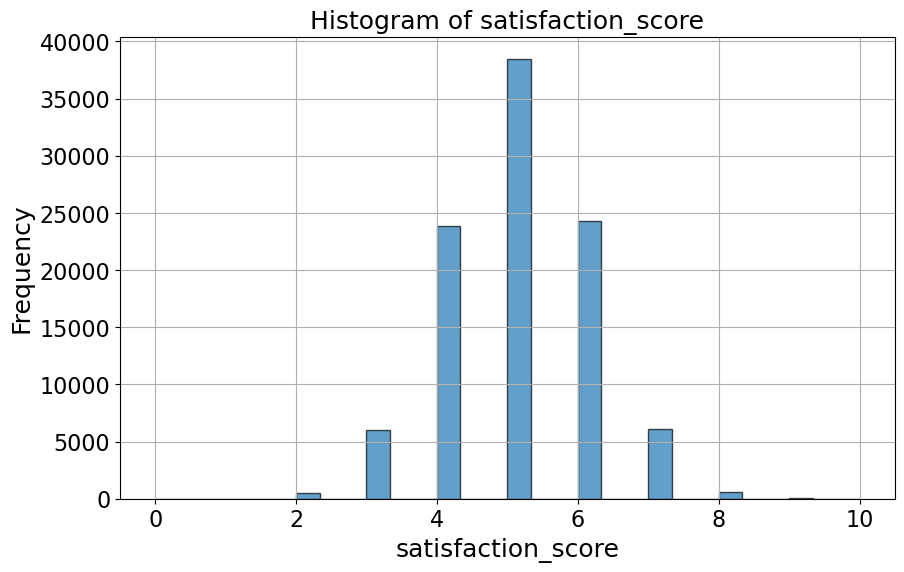

In [9]:
# Create univariate visualizations for each variable
for col in df.columns:
    if (df[col].dtype != 'category'):
        plt.figure(figsize=(10, 6))
        plt.hist(df[col], bins=30, edgecolor='k', alpha=0.7)
        plt.title(f'Histogram of {col}', fontsize=18)
        plt.xlabel(col, fontsize=18)
        plt.ylabel('Frequency', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.grid(True)
        plt.show()
    else:
        value_counts = df[col].value_counts().sort_index()
        value_counts.plot(kind='bar')
        plt.title(f'Distribution of {col}', fontsize=18)
        plt.xlabel(col, fontsize=18)
        plt.ylabel('Frequency', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.show()

# Bivariate Visualizations

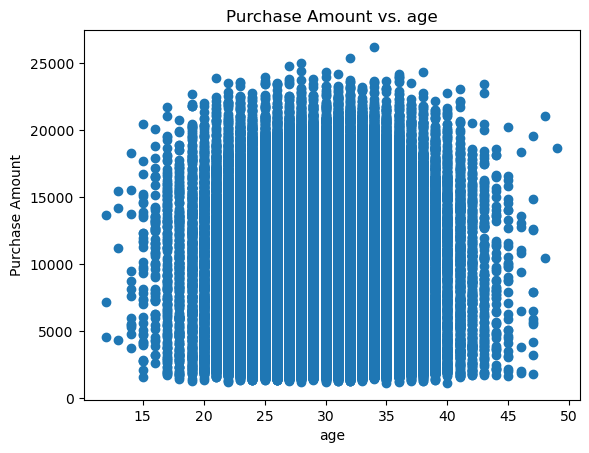

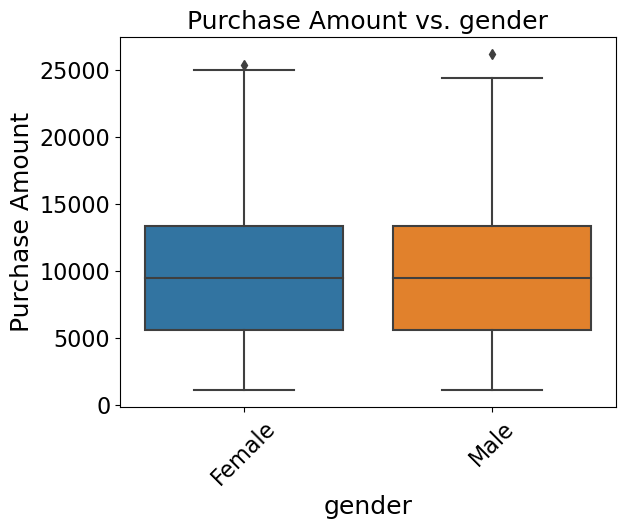

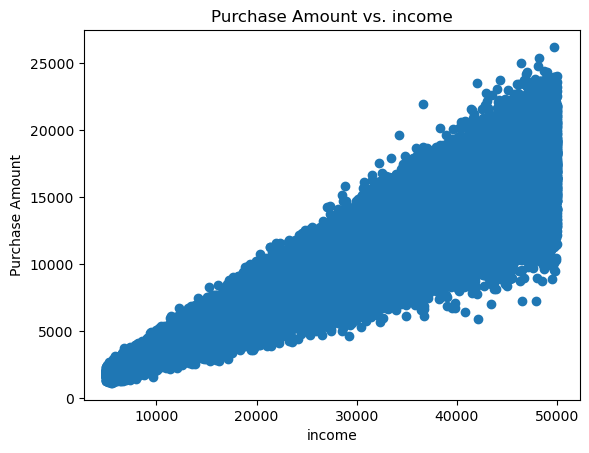

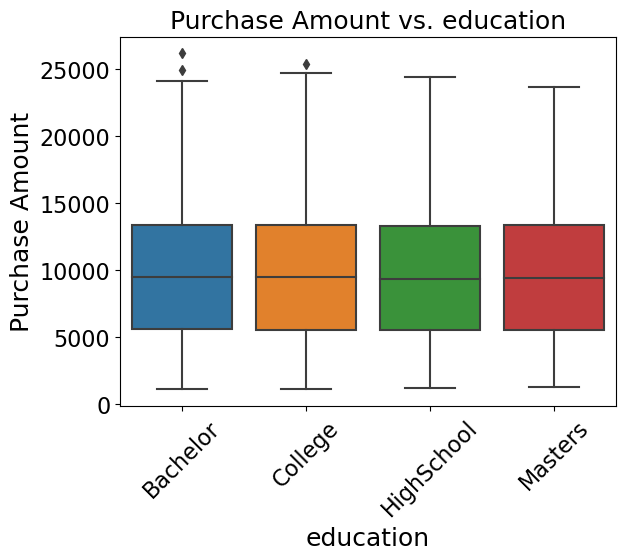

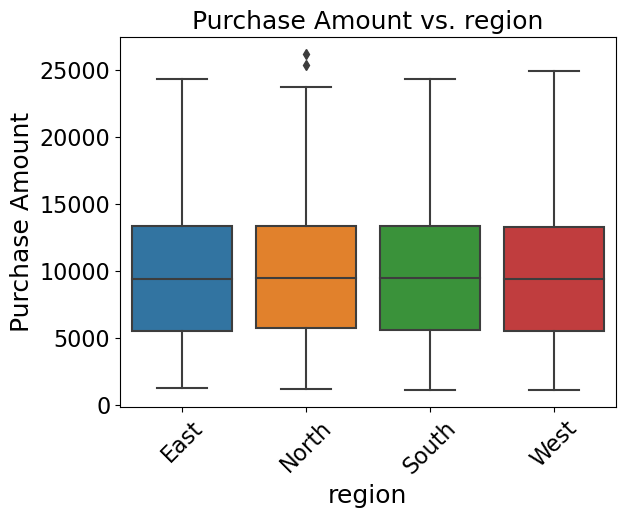

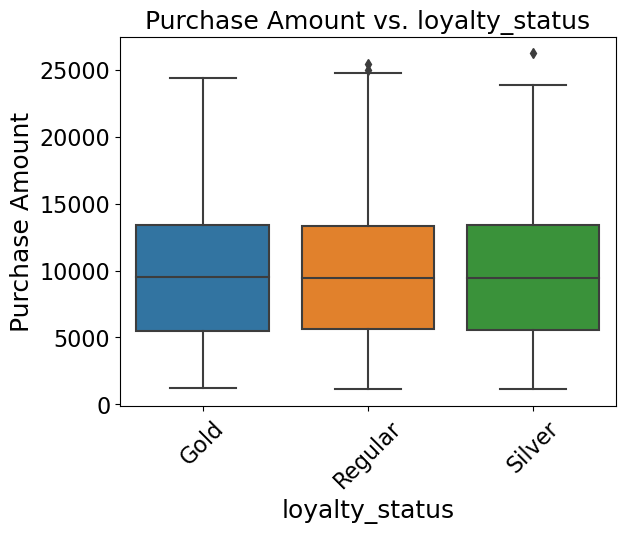

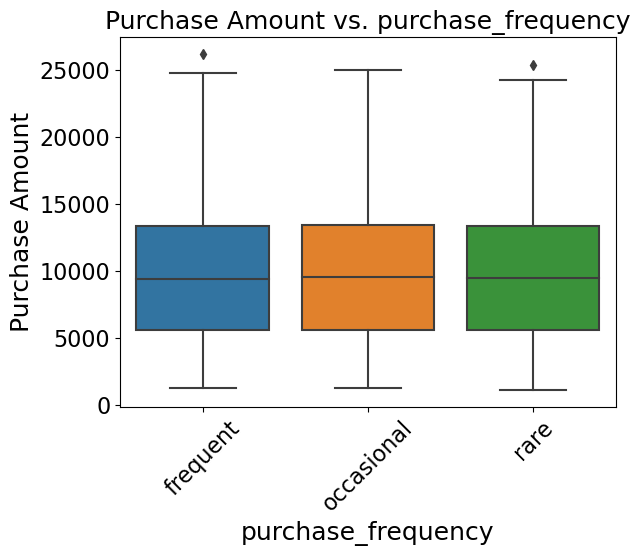

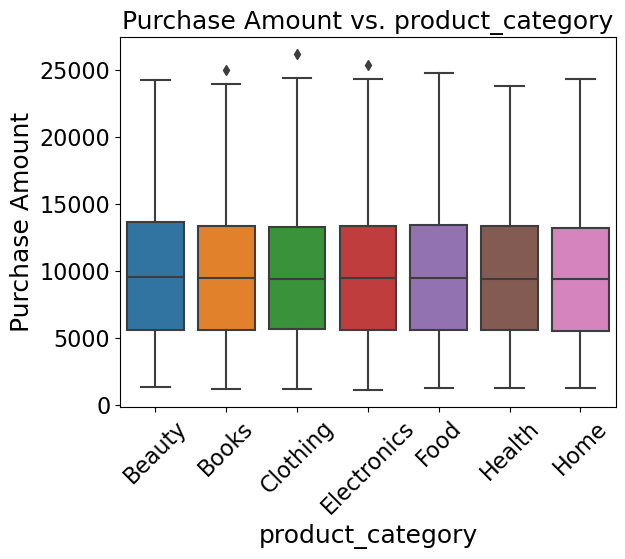

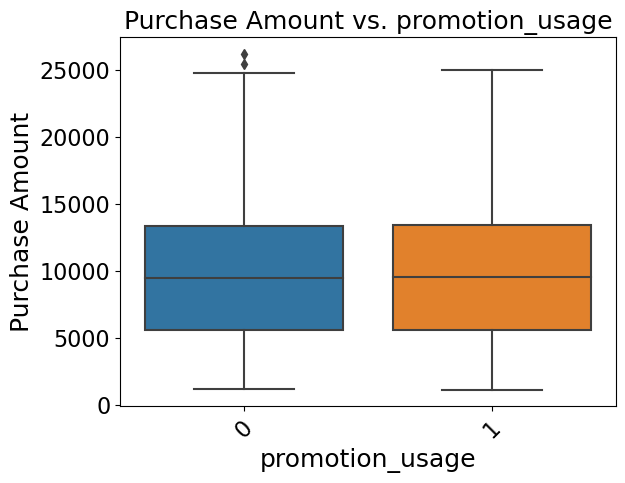

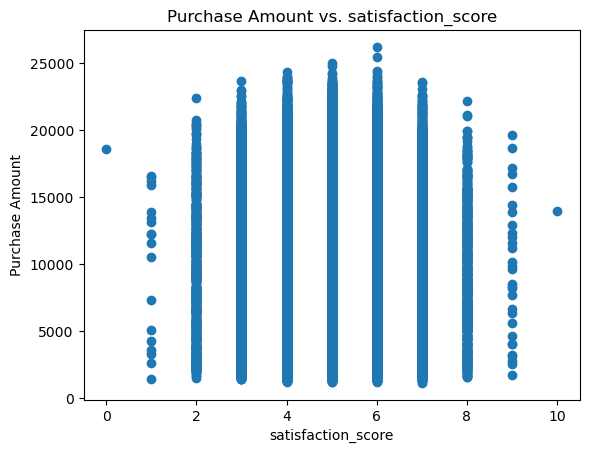

In [10]:
# Create bivariate visualizations for each dependent/independent variable combination
for col in df.columns:
    if col != 'purchase_amount':
        # Scatterplot if continuous vs. continuous
        if df[col].dtype != 'category':
            plt.scatter(df[col], df['purchase_amount'])
            plt.title(f'Purchase Amount vs. {col}')
            plt.xlabel(col)
            plt.ylabel('Purchase Amount')
            plt.show()
        # Boxplot if continuous vs. categorical
        else:
            sns.boxplot(x=col, y='purchase_amount', data=df)
            plt.title(f'Purchase Amount vs. {col}', fontsize=18)
            plt.xlabel(col, fontsize=18)
            plt.ylabel('Purchase Amount', fontsize=18)
            plt.tick_params(axis='x', which='major', labelsize=14, rotation=45)
            plt.tick_params(axis='both', which='major', labelsize=16)
            plt.show()

# Determine Parametric vs. Non-Parametric Method

This analysis utilizes RFR and KNN Regressor, both of which are non-parametric methods (Brownlee, 2020). However, it is good practice to make sure that such sophisticated methods are truly necessary, or if a simpler parametric method could be applied. Testing for the ability to use a parametric method consists of these steps: 

    1. Build and fit a linear regression model to produce residuals. 
    2. Check to see if the residuals are normally distributed (Barch, n.d.). 
    3. Check to see if the residuals have homoscedasticity (Barch, n.d.). 

Linear regression assumes that there is a linear relationship between the predictor variables and the target variables (Shields, 2024). Therefore, the Pearson correlation coefficient of each continuous predictor variable with the Purchase Amount target variable are calculated:

In [12]:
# Calculate Pearson correlation coefficients
continuous_variables = ['age', 'income', 'satisfaction_score']

correlations = df[continuous_variables].corrwith(df['purchase_amount'])
print(correlations)

age                  -0.002089
income                0.948441
satisfaction_score    0.003424
dtype: float64


The output above shows that, of the continuous predictor variables, only Income has a linear relationship with Purchase Amount with a Pearson correlation coefficient of 0.948441. 

ANOVA is used next to determine if there is a statistically significant difference in Purchase Amount across the levels of each categorical predictor variable (Eqibuana, 2021).

An advantage of ANOVA is that it allows you to test if there is a significant relationship between continuous and categorical variables (Eqibuana, 2021). A disadvantage of ANOVA is that the data is assumed to be normally distributed (Gandhi, 2022). However, in the context of this application of ANOVA during exploratory analysis, the normality requirement is not critical.

In [13]:
# ANOVA for Categorical vs Continuous (Eqibuana, 2021)
categorical_variables = ['gender', 'education', 'region', 'loyalty_status', 'purchase_frequency', 
                    'product_category', 'promotion_usage']

for var in categorical_variables:
    model = ols(f'purchase_amount ~ C({var})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"ANOVA results for {var}:")
    print(anova_table)
    print("\n")


ANOVA results for gender:
                 sum_sq       df        F    PR(>F)
C(gender)  1.496226e+04      1.0  0.00065  0.979667
Residual   2.303343e+12  99998.0      NaN       NaN


ANOVA results for education:
                    sum_sq       df         F    PR(>F)
C(education)  7.120691e+07      3.0  1.030477  0.377747
Residual      2.303272e+12  99996.0       NaN       NaN


ANOVA results for region:
                 sum_sq       df         F    PR(>F)
C(region)  5.212572e+07      3.0  0.754336  0.519648
Residual   2.303291e+12  99996.0       NaN       NaN


ANOVA results for loyalty_status:
                         sum_sq       df         F    PR(>F)
C(loyalty_status)  4.452398e+06      2.0  0.096648  0.907876
Residual           2.303338e+12  99997.0       NaN       NaN


ANOVA results for purchase_frequency:
                             sum_sq       df         F    PR(>F)
C(purchase_frequency)  3.191481e+07      2.0  0.692782  0.500185
Residual               2.303311e+12  99997.

The results of each ANOVA show that none of the categorical predictor variables have a statistically significant difference in Purchase Amount across their levels (as indicated by a PR(>F) value greater than 0.05) (Eqibuana, 2021). 

Given that Income is the only variable with a notable relationship to Purchase Amount, a simple linear regression model can be created with Income as the predictor variable and Purchase Amount as the target variable: 

In [14]:
# OLS Linear Regression (Geeks, 2024f)
# Define predictor and target variables
X = df[['income']]
y = df['purchase_amount']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
linear_model = sm.OLS(y, X).fit()

print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:        purchase_amount   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 8.954e+05
Date:                Wed, 19 Feb 2025   Prob (F-statistic):               0.00
Time:                        10:10:47   Log-Likelihood:            -8.7462e+05
No. Observations:              100000   AIC:                         1.749e+06
Df Residuals:                   99998   BIC:                         1.749e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2924     11.263     -0.204      0.8

The distribution of the residuals is checked using the Anderson-Darling test. This test was selected because Geeks for Geeks (2024d) writes that it has the advantage of working well on a wide variety of distributions. Geeks for Geeks also mentions that a disadvantage of the Anderson-Darling test is that it is designed for continuous distributions (which is not an issue in this analysis since we are testing the residuals). 

The output of the Anderson-Darling test on the residuals shows a test statistic of 772 which is significantly higher than any of the critical values. This means the residuals are not normally distributed.

In [15]:
# Anderson-Darling Test on residuals (SciPy, 2024)
residuals = linear_model.resid
result_ad = anderson(residuals)

print('Anderson-Darling Test on Residuals:')
print(f'Statistic: {result_ad.statistic}')
print(f'Critical Values: {result_ad.critical_values}')
print(f'Significance Levels: {result_ad.significance_level}')

Anderson-Darling Test on Residuals:
Statistic: 772.0250552234793
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Significance Levels: [15.  10.   5.   2.5  1. ]


The final test to justify using non-parametric methods for analysis is to check if the residuals have homoscedasticity using the Breusch-Pagan test. Zach Bobbitt (2020) writes that an advantage of this test is that it allows us to check if the residuals have homoscedasticity or constant variance. A disadvantage of the Breusch-Pagan test is that it is sensitive to residuals that are not normally distributed (Rehal, 2023). Therefore, the results will be interpreted with caution in this analysis because the residuals are already found to not be normally distributed.

In [16]:
# Breusch-Pagan test for homoscedasticity (Bobbitt, 2020)
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']

bp_test = het_breuschpagan(residuals, linear_model.model.exog)
lzip(names, bp_test)

[('Lagrange multiplier statistic', 15398.7082112227),
 ('p-value', 0.0),
 ('f-value', 18201.140799957782),
 ('f p-value', 0.0)]

The output above shows a very high Lagrange multiplier statistic at 15,398 and a very high f-value at 18,201. These two high test statistics, accompanied by the p-value and f p-value of 0.0 indicate that the null hypothesis indicating that homoscedasticity is present is rejected and that the residuals have heteroscedasticity (Bobbitt, 2020). 

Because the residuals of a fitted linear model are not normally distributed, it is determined that the non-parametric methods of a RFR and KNN Regressor are justified.

In [17]:
# Determine range of Purchase Amount (used later for evaluating model performance)
purchase_amount_range = df['purchase_amount'].max() - df['purchase_amount'].min()
print(f'The range of the Purchase Amount variable is {purchase_amount_range}')

threshold = (purchase_amount_range * 0.05)
print(f'5% of the Purchase Amount Range is {threshold}')

The range of the Purchase Amount variable is 25086
5% of the Purchase Amount Range is 1254.3000000000002
